In [4]:
from lcms_processing_functions import *
from summary_excel import create_compound_summary
import matplotlib.pyplot as plt

def process_compound_data(file_path):
    """
    Reads an Excel file, processes each compound, and stores processed data in a dictionary.

    Parameters:
    - file_path (str): Path to the Excel file containing raw data.

    Returns:
    - dict: Dictionary with processed data for each compound, including calibration, concentrations, QC, and replicate statistics.
    """
    # Read the Excel file
    df = pd.read_excel(file_path)
    compound_dict = {}

    # Process each compound separately
    for compound, data in df.groupby('Compound'):
        compound_name = compound.split('_')[-1]
        
        # Perform calibration and calculate concentrations
        cal_std_df, LOQ = process_calibration(data)
        cal_curve = get_calibration_curve(cal_std_df, LOQ)
        samples_df = process_samples(data)
        cal_std_df = calculate_concentrations(cal_std_df, LOQ, cal_curve)
        samples_df = calculate_concentrations(samples_df, LOQ, cal_curve)
        
        # Modify 'Sample Type' for categorization
        samples_df = sample_type(samples_df)
        
        # Perform blank subtraction
        samples_df = subtraction(samples_df)

        # Perform QC calculations
        dup_precision_df = duplication_comparison(samples_df)
        spike_precision_df = spike_comparison(samples_df)
        qc_precision_df = qc_comparison(samples_df, cal_std_df)

        # Calculate replicate statistics
        replicate_stats_df = replicate_stats(samples_df)

        # Store all processed data in the compound dictionary
        compound_dict[compound_name] = {
            'Cal Std': cal_std_df,
            'Sample': samples_df,
            'LOQ': LOQ,
            'Regression results': cal_curve,
            'Duplication Precision': dup_precision_df,
            'Spike Precision': spike_precision_df,
            'QC Precision': qc_precision_df,
            'Replicate Statistics': replicate_stats_df
        }

    return compound_dict

def plot_concentrations_by_sample(compound_dict):
    """
    Creates one plot per sample, each showing the average concentration of the sample across all compounds,
    with error bars representing the standard deviation. The y-axis minimum is set to zero, and the upper limit 
    includes a buffer above the max concentration plus the standard deviation.

    Parameters:
    - compound_dict (dict): Dictionary containing processed data for each compound, including replicate statistics.
    """
    # Initialize a dictionary to store plot data for each sample
    sample_data = {}

    # Collect data from each compound's replicate statistics
    for compound_name, data in compound_dict.items():
        replicate_stats_df = data.get('Replicate Statistics')
        
        # Check if replicate statistics are available
        if replicate_stats_df is not None:
            for _, row in replicate_stats_df.iterrows():
                sample_name = row['Sample Name']
                avg_concentration = row['Average_Concentration']
                std_dev = row['Standard_Deviation']
                
                # Store data in sample_data for each sample name
                if sample_name not in sample_data:
                    sample_data[sample_name] = {'Compound': [], 'Average Concentration': [], 'Standard Deviation': []}
                
                sample_data[sample_name]['Compound'].append(compound_name)
                sample_data[sample_name]['Average Concentration'].append(avg_concentration)
                sample_data[sample_name]['Standard Deviation'].append(std_dev)
    
    # Plot each sample across compounds
    for sample_name, data in sample_data.items():
        # Ensure that data exists and is valid for plotting
        avg_concentrations = [val for val in data['Average Concentration'] if pd.notna(val)]
        std_devs = [val for val in data['Standard Deviation'] if pd.notna(val)]
        
        if not avg_concentrations:
            print(f"No valid data to plot for sample '{sample_name}'.")
            continue
        
        plt.figure(figsize=(15, 5))
        
        # Create bar plot with error bars for standard deviation
        plt.bar(
            data['Compound'], 
            data['Average Concentration'], 
            yerr=data['Standard Deviation'], 
            capsize=5, 
            color='skyblue'
        )

        # Configure plot aesthetics
        plt.xlabel("Compound")
        plt.ylabel("Average Concentration")
        plt.title(f"Average Concentration for Sample '{sample_name}' Across Compounds")
        plt.xticks(rotation=60, ha='right')
        
        # Set y-axis minimum to zero and add a 10% buffer to the upper bound
        max_y = max(avg_concentrations) + (max(std_devs) if std_devs else 0)
        buffer = 0.1 * max_y  # 10% buffer
        plt.ylim(0, max_y + buffer)
        
        plt.tight_layout()
        plt.show()

In [5]:
#### Insert your input Excel spreadsheet filepath below ####
file_path = './20231114_Alaskan_Community_Waters_updatedCal_Lv.xlsx'
compound_dict = process_compound_data(file_path)

No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching Ctrl sample found for Spike ''
No matching

In [6]:
#### Would you like an Excel spreadsheet with average concentrations and QC? ####

#### Insert your desired output Excel spreadsheet filepath below ####
output_file = './Alaskan_Community_Waters_data.xlsx'
create_compound_summary(compound_dict, output_file)

Excel file saved to './Alaskan_Community_Waters_data.xlsx' with three sheets: LOQ, Concentrations, and QC.


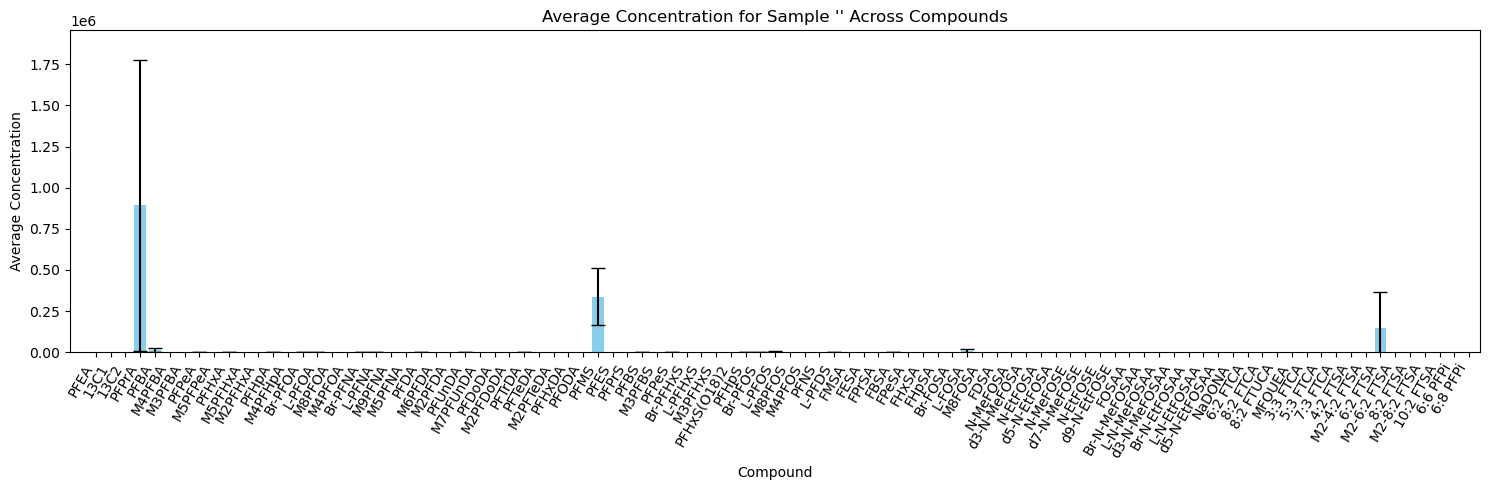

In [7]:
plot_concentrations_by_sample(compound_dict)